In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# a is current, b is upstream, c is downstream, d is source
def tdma(N, a, b, c, d, T, TW, TE):
    P = np.zeros(N)
    Q = np.zeros(N)

    # west BC, T[0] is known so P[0] = 0 and Q[0] is T[0]
    P[0] = 0
    Q[0] = TW
    # setting up the inside elements forwards
    for i in range(1, N-1): 
        P[i] = b[i] / (a[i] - c[i] * P[i-1])
        Q[i] = (d[i] + c[i] * Q[i-1]) / (a[i] - c[i] * P[i-1])
    # east BC, T[N] is known
    P[N-1] = 0
    Q[N-1] = TE
    for i in range(N-2, -1, -1): # backwards solve
        T[i] = P[i] * T[i+1] + Q[i]

    return T.copy()

def analytical(grid, L, Pe, Phi_0, Phi_L):
    return Phi_0 + ((np.exp(grid * Pe / L) - 1) / (np.exp(Pe) - 1) * (Phi_L-Phi_0))

def error_calc(grid, analytical, numerical):
    return 100 * (sum(abs((numerical - analytical)/analytical)) / grid)

def plotting(grid, analytical_results, title, scheme_results, error_value, Pe_G, Pe_L):
    fig, ax = plt.subplots() # values are rounded for display, not processing
    ax.plot(grid, analytical_results, label=f'Analytical', c='black')
    ax.plot(grid, scheme_results, label=f'Numerical, Error:{round(error_value,2)}%', 
            c='blue', ls='--', marker='o', mfc='red') 

    ax.set_title(f"{title}, Pe Global: {round(Pe_G,3)}, Pe Local: {round(Pe_L,3)}")
    ax.set_xlabel('x / L')
    ax.set_ylabel('Temperature (°C)')
    ax.legend()

    return plt.show()

def error_dx(dx, cds_err, uds_err, pds_err, u, gamma, density):
    fig, ax = plt.subplots()
    ax.plot(dx, cds_err, label='CDS', color='blue', marker='o')
    ax.plot(dx, uds_err, label='UDS', color='green', marker='s')
    ax.plot(dx, pds_err, label='PLDS', color='red', marker='^')

    ax.set_title("Grid-Point Spacing vs. Cell Count\n"
    fr"$\rho = {density}$ kg/m$^3$, $\Gamma_\phi = {gamma}$ kg/ms, $u = {u}$ m/s" + "\n")
    ax.set_xlabel(fr"$\Delta$ x (m)")
    ax.set_ylabel('Error (%)')
    ax.set_yscale('log')
    ax.secondary_xaxis(
        'top', functions=(lambda x: x * density * u / gamma, lambda x: x / (density * u / gamma))
        ).set_xlabel("Local Peclet Number ($Pe_{local}$)")
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    ax.legend()
    
    return plt.show()

In [ ]:
def cds(N, gamma, dx, rho, u, T, TW, TE):
    aP, aE, aW, b = np.zeros((4,N))
    for i in range(1,N-1):
        aE[i] = gamma / dx - 0.5 * rho * u
        aW[i] = gamma / dx + 0.5 * rho * u
        aP[i] = aE[i] + aW[i] + b[i]

    return tdma(N, aP, aE, aW, b, T, TW, TE)

def uds(N, gamma, dx, rho, u, T, TW, TE):
    aP, aE, aW, b = np.zeros((4,N))
    for i in range(1, N-1):
        aE[i] = gamma / dx + max(-(rho * u), 0)
        aW[i] = gamma / dx + max((rho * u), 0)
        aP[i] = aE[i] + aW[i] + b[i]
  
    return tdma(N, aP, aE, aW, b, T, TW, TE)

def pds(N, gamma, dx, rho, u, T, TW, TE, Pe):
    aP, aE, aW, b = np.zeros((4,N))
    for i in range(1, N-1):
        aE[i] = (gamma / dx) * max((1 - 0.1 * abs(Pe))**5,0) + max(-(rho * u), 0)
        aW[i] = (gamma / dx) * max((1 - 0.1 * abs(Pe))**5,0) + max((rho * u), 0)
        aP[i] = aE[i] + aW[i] + b[i]
        
    return tdma(N, aP, aE, aW, b, T, TW, TE)

In [ ]:
def solve(length, cell_count, gamma_T, density, vel, T_West, T_East):
    # Domain setup
    delta_x = length / (cell_count - 1)
    x = np.linspace(0, length, cell_count) 
    Temp = np.full(cell_count, T_East) # deg C

    Pe_local = (density * vel * delta_x / gamma_T)
    Pe_global = (density * vel * length / gamma_T)
    T_analytical = analytical(x, length, Pe_global, T_West, T_East)
    results = {
        "CDS" : cds(cell_count, gamma_T, delta_x, density, vel, Temp, T_West, T_East), 
        "UDS" : uds(cell_count, gamma_T, delta_x, density, vel, Temp, T_West, T_East), 
        "PLDS" : pds(cell_count, gamma_T, delta_x, density, vel, Temp, T_West, T_East, Pe_local)
        }
    errors = {name: error_calc(cell_count, T_analytical, res) for name, res in results.items()}
    
    return delta_x, x, T_analytical, results, errors, Pe_local, Pe_global

Solving for Cell Count = 31
Grid Spacing = 0.03333333333333333


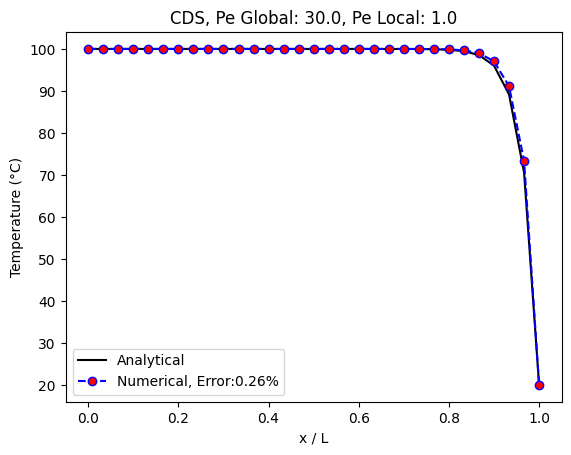

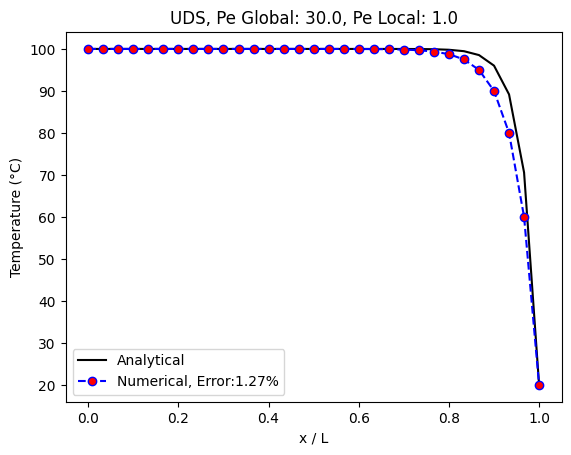

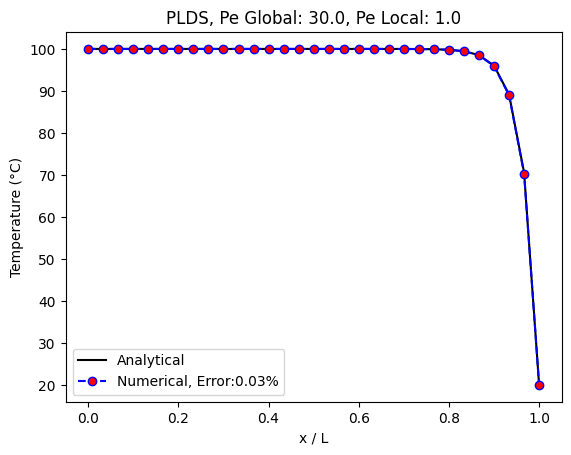

Solving for Cell Count = 11
Grid Spacing = 0.1


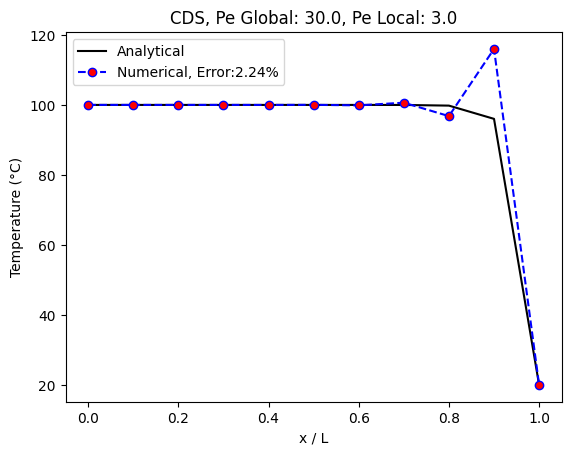

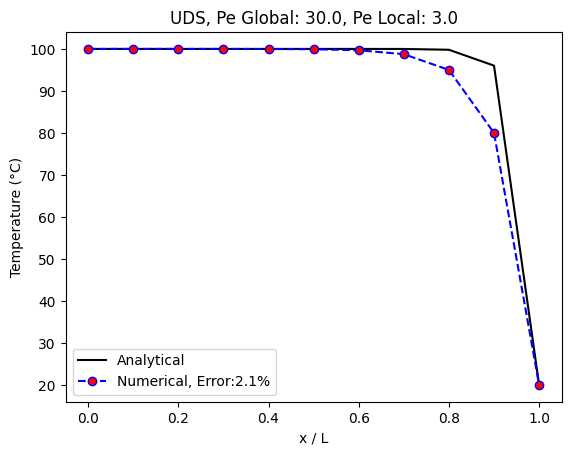

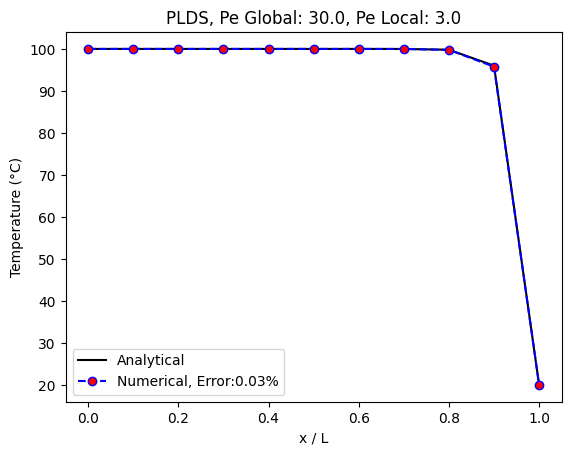

Solving for Cell Count = 7
Grid Spacing = 0.16666666666666666


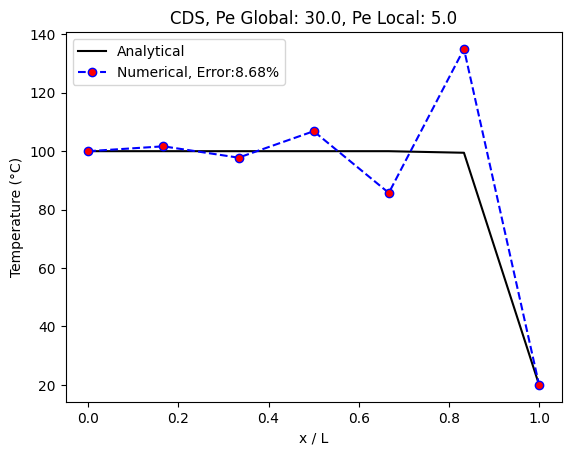

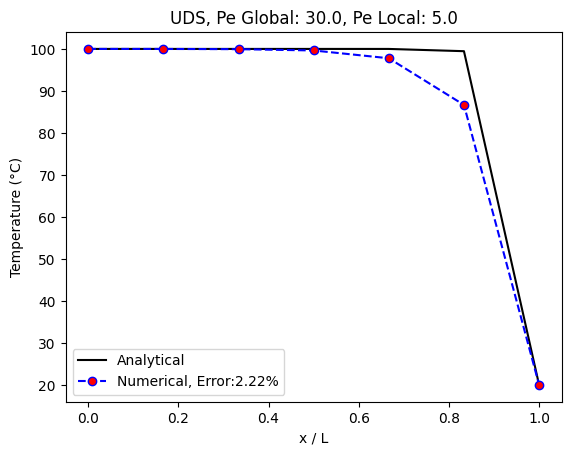

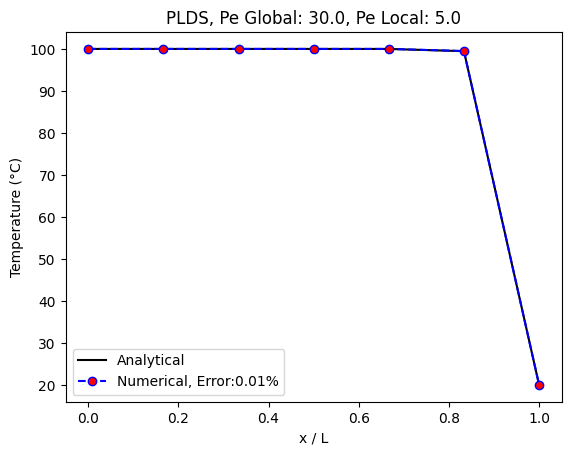

Solving for Cell Count = 4
Grid Spacing = 0.3333333333333333


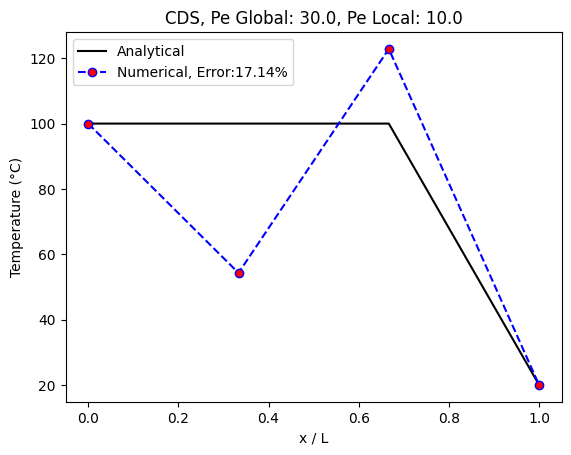

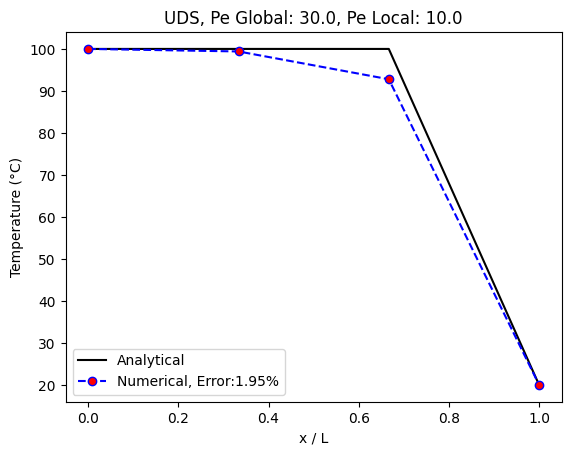

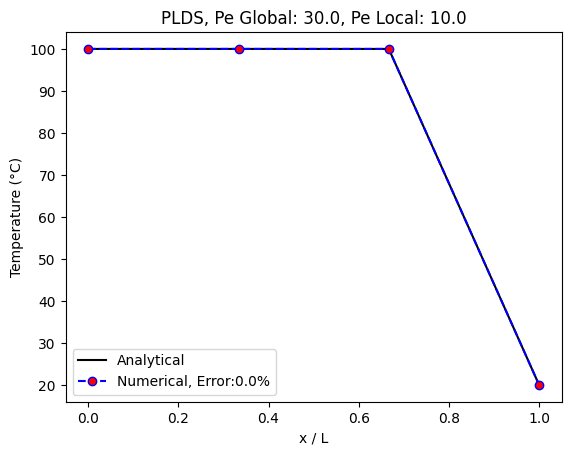

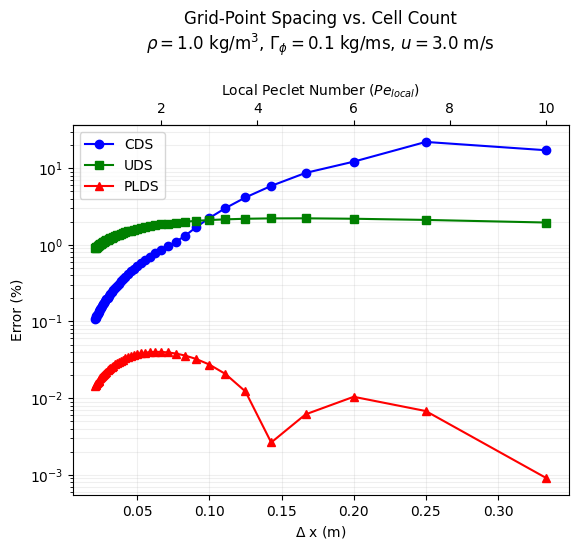

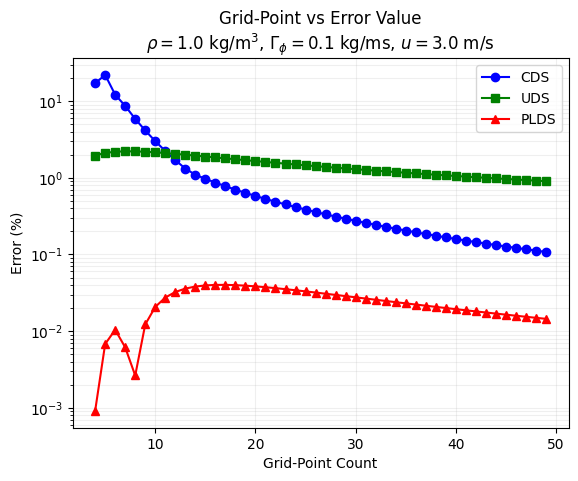

In [ ]:
L, rho, gamma_T, u, TW, TE = 1.0, 1.0, 0.1, 3.0, 100.0, 20.0

# Compare between schemes
cell_counts = [31, 11, 7, 4]
for N in cell_counts:
    print(f"Solving for Cell Count = {N}")
    dx, x, T_analytical, results, errors, Pe_L, Pe_G = solve(L, N, gamma_T, rho, u, TW, TE)
    print(f"Grid Spacing = {dx}")
    for name in results:
        plotting(x, T_analytical, f"{name}", results[name], errors[name], Pe_G, Pe_L)

# Comparing error values in each scheme for dx, cell count, and Pe
cell_count, err_cds, err_uds, err_pds, dx_list = [i for i in range(4,50,1)], [], [], [], []
for i in cell_count:
    dx, x, T_analytical, results, errors, Pe_L, Pe_G = solve(L, i, gamma_T, rho, u, TW, TE)
    dx_list.append(dx)
    err_cds.append(errors["CDS"])
    err_uds.append(errors["UDS"])
    err_pds.append(errors["PLDS"])

error_dx(dx_list, err_cds, err_uds, err_pds, u, gamma_T, rho)